## Epidemic-Behavior Interaction Model (EBIM)

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.fft import fft, fftfreq
from scipy.ndimage import gaussian_filter

class Node: 

    def __init__(self, node_id, a, b, gamma, eta) -> None:
        """
        Initialize a Node with an ID and initial state.
        
        Args:
        - node_id (int): Unique identifier for the node.
        - state_awareness (int): 0 for unaware (U), 1 for aware (A).
        - state_disease (int): 0 for susceptible (S), 1 for infected (I).
        """

        self.id = node_id
        self.state_disease = 0
        self.state_awareness = 0

        self.new_state_disease = 0
        self.new_state_awareness = 0

        self.physical_neighbors = []
        self.virtual_neighbors = []

        # self.aware_therold = 0.4
        # self.aware_therold = np.random.uniform(0.05, 0.95)
        # self.aware_therold = np.random.normal(0.5, 0.25)
        self.aware_therold = np.random.beta(a, b)

        self.infected_time = -1

        self.gamma = gamma
        self.eta = eta

    def add_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.append(neighbor_node)
    
    def remove_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.remove(neighbor_node)

    def add_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.append(neighbor_node)

    def remove_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.remove(neighbor_node)

    def get_physical_neighbors_id(self):
        return [neighbors.id for neighbors in self.physical_neighbors]

    def get_virtual_neighbors_id(self):
        return [neighbors.id for neighbors in self.virtual_neighbors]

    def turn_into_aware(self, time: int):
        self.new_state_awareness = 1
        self.forget_time = time + np.random.exponential(60) # rate of forgetting

    def turn_into_unaware(self):
        self.new_state_awareness = 0
        self.forget_time = -1
        
    def turn_into_infectious(self, time: int):
        self.new_state_disease = 1
        self.infected_time = time

    def turn_into_susceptible(self): # recover
        self.new_state_disease = 0
        self.infected_time = -1

    def update_to_new_state(self):
        self.state_disease = self.new_state_disease
        self.state_awareness = self.new_state_awareness

    def rewire(self, all_susceptible_nodes):
        for neighbor in random.sample(self.physical_neighbors, len(self.physical_neighbors)):
            # break the link with the infected neighbor at probability gamma
            if neighbor.state_disease == 1 and np.random.rand() < self.gamma:
                
                # rewire to a neighbor of a neighbor (nodes at distance 2) at probability eta
                if np.random.rand() < self.eta:
                    new_links_pool = set()
                    for n in self.physical_neighbors:
                        if n.id != neighbor.id:
                            new_links_pool.update(n.physical_neighbors) 
                    [new_links_pool.discard(n) for n in list(new_links_pool) if n.state_disease == 1] # remove the infected modes
                # rewire to random susceptible node at probability 1 - eta
                else:
                    new_links_pool = set(all_susceptible_nodes)
                
                new_links_pool = new_links_pool - set(self.physical_neighbors)
                new_links_pool.discard(self)
                # print(self.id, neighbor.id, [n.id for n in list(new_links_pool)], [n.id for n in all_susceptible_nodes])

                if len(new_links_pool) > 0:
                    new_neighbor = random.choice(list(new_links_pool))
                    self.add_physical_neighbor(new_neighbor)
                    new_neighbor.add_physical_neighbor(self)

                    self.remove_physical_neighbor(neighbor)
                    neighbor.remove_physical_neighbor(self)

                    return 1
        return 0

class TwoLayerNetwork:
    def __init__(self, N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, psi="", lambda_="", rho="", network_type="ER", initial_infected_ratio=0.01, intial_aware_ratio=0.1):
        """
        Initialize a two-layer network with N nodes in each layer.

        Args:
        - N (int): Number of nodes in each layer.
        - rewiring_percentage (float): Percentage of edges to rewire in the virtual network
        - beta_a (float): Transmission probability for aware nodes.
        - beta_u (float): Transmission probability for unaware nodes.
        - alpha (float): Probability of recovery.
        - infection_period (int): Duration of the infection period.
        - gamma (float): Probability of rewiring the physical network.
        - eta (float): Probability of rewiring to a neighbor of a neighbor.
        - threshold_formula (str): "simple" or "complex".
        - psi (float): Transmission probability for aware nodes in the simple contagion model.
        - lambda_ (float): Rate of change in the awareness threshold.
        - rho (float): Rate of change in the awareness threshold.
        - network_type (str): Type of the physical network: "ER", "BA", or "WS".
        - initial_infected_ratio (float): Initial fraction of infected nodes.
        - intial_aware_ratio (float): Initial fraction of aware nodes.
        """
        # Create N nodes 
        self.nodes = [Node(node_id=i, a=a, b=b, gamma=gamma, eta=eta) for i in range(N)]

        # Infect a fraction of the nodes
        num_infected = int(initial_infected_ratio * N)
        infected_nodes = np.random.choice(self.nodes, num_infected, replace=False)
        for node in infected_nodes:
            node.turn_into_infectious(time=0)
        
        # Make a fraction of the nodes aware
        num_aware = int(intial_aware_ratio * N)
        aware_nodes = np.random.choice(self.nodes, num_aware, replace=False)
        for node in aware_nodes:
            node.turn_into_aware(0)

        for node in self.nodes:
            node.update_to_new_state()

        # Create the physical network
        p = k/N
        if network_type == "ER":
            G = nx.erdos_renyi_graph(n=N, p=p)
        elif network_type == "BA":
            G = nx.barabasi_albert_graph(n=N, m=k)
        elif network_type == "WS":
            G = nx.connected_watts_strogatz_graph(n=N, k=k, p=0.5)
        else:
            raise ValueError("Invalid network type. Choose 'ER', 'BA', or 'WS'.")
        
        self.create_physical_network(G)

        # Create the virtual network by copying the physical network
        # nx.double_edge_swap(G, nswap=int((1-overlap_percentage)) # rewire the network by performing double edge swaps
        self.create_virtual_network(G)

        # Set the parameters of the model
        self.N = N
        self.k = k
        self.p = p
        self.a = a
        self.b = b
        
        self.beta_a = beta_a
        self.beta_u = beta_u
        self.alpha = alpha
        self.infection_period = infection_period  
        self.gamma = gamma
        self.eta = eta

        self.threshold_formula = threshold_formula
        self.psi = psi
        self.lambda_ = lambda_
        self.rho = rho
        if self.rho == 0:
            self.rho = 0.01
        
        self.initial_infected_ratio = initial_infected_ratio
        self.intial_aware_ratio = intial_aware_ratio
        self.network_type = network_type

        self.round = 0
        self.rewiring_count = 0
        self.infection_counts = [self.count_infected()]
        self.awreness_counts = [self.count_aware()]
        self.adjust_awareness_thresholds = [] # for recording the adjusted awareness thresholds

    def create_physical_network(self, G):
        """
        Create the physical network by adding physical neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the physical network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_physical_neighbor(self.nodes[neighbor])
    
    def create_virtual_network(self, G):
        """
        Create the virtual network by adding virtual neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the virtual network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_virtual_neighbor(self.nodes[neighbor])
    
    def update_health_state(self):
        """
        Update the health state of each node in the network.
        """
        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible: S -> I
            if node.state_disease == 0: 
                # 1. count the number of infected neighbors
                num_infected_neighbors = sum([neighbor.state_disease == 1 for neighbor in node.physical_neighbors])

                # 2. calculate the probability of transmission
                if node.state_awareness == 1:
                    transmission_prob = 1 - (1 - self.beta_a) ** num_infected_neighbors
                else:
                    transmission_prob = 1 - (1 - self.beta_u) ** num_infected_neighbors

                # 3. set the state of the node to infected with probability 'transmission_prob'
                if np.random.rand() < transmission_prob:
                    node.turn_into_infectious(time=self.round)

            # If the node is infected: I -> S
            elif node.state_disease == 1: 
                if self.round - node.infected_time >= self.infection_period: 
                    if np.random.rand() < self.alpha:
                        node.turn_into_susceptible()
    
    def update_awareness_state(self):
        """
        Update the awareness state of each node in the network.
        """
        if self.threshold_formula == "simple": # simple contagion
            for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is unaware: U -> A
                if node.state_awareness == 0: 
                    # 1. count the number of awared neighbors
                    num_awared_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors])

                    # 2. calculate the probability of transmission
                    transmission_prob = 1 - (1 - self.psi) ** num_awared_neighbors

                    # 3. set the state of the node to awared with probability 'transmission_prob'
                    if np.random.rand() < transmission_prob:
                        node.turn_into_aware(time=self.round)

                # If the node is awared: I -> S
                elif node.state_awareness == 1: 
                    if self.round >= node.forget_time: 
                        node.turn_into_unaware()
        
        elif self.threshold_formula == "complex": # complex contagion
            global_infection_rate = self.count_infected() / len(self.nodes)
            
            for node in random.sample(self.nodes, len(self.nodes)):
            
                if len(node.virtual_neighbors) == 0:
                    continue

                # 1. count the proportion of aware neighbors
                proportion_aware_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors]) / len(node.virtual_neighbors) 

                # 2. decide the threshold for turning into aware
                adjusted_threshold = node.aware_therold * (1 - self.lambda_*global_infection_rate) * (1/self.rho)
                adjusted_threshold = np.clip(adjusted_threshold, 0, 1)
                self.adjust_awareness_thresholds.append(adjusted_threshold)

                # 3. set the state of the node to aware if the threshold is met
                if proportion_aware_neighbors > adjusted_threshold:
                    node.turn_into_aware(time=self.round)
                else:
                    node.turn_into_unaware()
        
    def update_physical_network(self):
        """
        Update the network structure at the physical layer.
        """
        # get all susceptible nodes
        all_susceptible_nodes = [node for node in self.nodes if node.state_disease == 0]

        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible
            if node.state_disease == 0:
                self.rewiring_count += node.rewire(all_susceptible_nodes)
    
    def update_virtual_network(self):
        """
        Update the network structure at the virtual layer.
        """
        for node in self.nodes:
            node.virtual_neighbors = node.physical_neighbors.copy()
    
    def count_infected(self):
        return sum(node.state_disease == 1 for node in self.nodes)
    
    def count_aware(self):
        return sum(node.state_awareness == 1 for node in self.nodes)
    
    
    def update_one_round(self):
        self.round += 1
        self.adjust_awareness_thresholds = [] # for recording the adjusted awareness thresholds

        self.update_health_state()
        self.update_awareness_state()
        for node in self.nodes:
            node.update_to_new_state()

        self.update_physical_network()
        self.update_virtual_network()

        # Record the number of infected and aware nodes
        self.infection_counts.append(self.count_infected())
        self.awreness_counts.append(self.count_aware())
            
    
    def run_simulation(self, num_rounds, print_info=True, plot_network=True):
        if print_info: self.print_info()

        for t in range(num_rounds):
            self.update_one_round()
            
            if plot_network and (t % 300 == 0):
                pi = self.count_infected() / len(self.nodes)
                print(f"Time step: {self.round}")
                print(f"Awareness count: {self.count_aware()}")
                plt.figure(figsize=(3, 2))
                plt.hist(self.adjust_awareness_thresholds, bins=50, edgecolor='black')
                plt.xlim(0, 1) 
                plt.title(f'Global Infection rate={pi:.2f}')
                plt.show()
                self.plot_network("physical")

        if print_info: self.print_info()


    def get_network(self, layer):
        """
        Get the network of the specified layer.

        Args:
        - layer (str): "physical" or "virtual"
        """
        G = nx.Graph()
        edge_list = []

        for node in self.nodes:
            if node.state_awareness == 1 and node.state_disease == 1:
                color = 'skyblue' # A and I
            elif node.state_awareness == 0 and node.state_disease == 1:
                color = 'darkblue' # U and I
            elif node.state_awareness == 1 and node.state_disease == 0:
                color = 'gray' # A and S
            else: 
                color = 'black' # U and S
            G.add_node(node.id, color=color)

            if layer == "physical":
                for neighbor in node.physical_neighbors:
                    edge_list.append((node.id, neighbor.id))
        
            elif layer == "virtual":
                for neighbor in node.virtual_neighbors:
                    edge_list.append((node.id, neighbor.id))

        G.add_edges_from(edge_list)
        return G
    

    def plot_network(self, layer="physical", component_num=2):
        G = self.get_network(layer)

        connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
        largest_components = connected_components[:component_num]
        subgraphs = [G.subgraph(component).copy() for component in largest_components]
        pos = nx.spring_layout(G, seed=42) 
        plt.figure(figsize=(8, 6))
        for subgraph in subgraphs:
            node_colors = nx.get_node_attributes(subgraph, 'color').values()
            nx.draw(
                subgraph,
                pos, 
                with_labels=False,
                node_color=node_colors,
                node_size=2.5,
                edge_color='lightgray',
                width=0.5
            )
        
        colors = ['skyblue', 'darkblue', 'gray', 'black']
        labels = ['I+A: Infected and Adopting', 'I+N: Infected and Not Adopting', 'S+A: Susceptible and Adopting', 'S+N: Susceptible and Not Adopting']
        for color, label in zip(colors, labels):
            plt.scatter([], [], color=color, label=label)

        plt.legend(title="Node Status", loc="best")
        plt.title(f"Largest {component_num} Components of the Graph")
        plt.show()
        

    def print_info(self):
        print(f"Parameters: N={self.N}, k={self.k}, a={self.a}, b={self.b}, beta_a={self.beta_a}, beta_u={self.beta_u}, alpha={self.alpha}, infection_period={self.infection_period}, gamma={self.gamma}, eta={self.eta}, threshold_formula={self.threshold_formula}, psi={self.psi}, lambda={self.lambda_}, rho={self.rho}, network_type={self.network_type}, initial_infected_ratio={self.initial_infected_ratio}, intial_aware_ratio={self.intial_aware_ratio}")
        print(f"Number of Infected, Aware: {self.count_infected()}, {self.count_aware()}")
        print(f"Physical, Virtual network: {self.get_network('physical').number_of_edges()}, {self.get_network('virtual').number_of_edges()} edges")
        print(f"The number of isolated nodes: {nx.number_of_isolates(self.get_network('physical'))}")
        print(f"Clustering coefficient, Transitivity: {nx.average_clustering(self.get_network('physical')):.6f}, {nx.transitivity(self.get_network('physical')):.6f}")
        print('-'*30)


    def plot_prevalence_trend(self, ax=None):
        time_steps = self.round
        infection_proportion = np.array(self.infection_counts) / self.N
        awareness_proportion = np.array(self.awreness_counts) / self.N
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 7))  # Create a new figure if no axes provided
        ax.plot(range(time_steps+1), infection_proportion, label='I: Infected population')
        ax.plot(range(time_steps+1), awareness_proportion, label='A: Adopting population', color='orange')

        # ax.title('EBIM: SIS + NAN Model')
        ax.set_xlabel('Time step (Iteration)')
        ax.set_ylabel('Percentage of agents')
        ax.legend()
        ax.set_ylim(-0.05, 1.05)
        # if ax.figure:
        #     plt.show()

    def get_statistics(self, type, window_size=1000):
        if type == "infection":
            y = np.array(self.infection_counts) / self.N
        elif type == "awareness":
            y = np.array(self.awreness_counts) / self.N
        else:
            raise ValueError("Invalid type. Choose 'infection' or 'awareness'.")
        
        last_segment = y[-window_size:]

        # 1. navie version
        amplitude = last_segment.max() - last_segment.min() # amplitude: Max-Min
        std = last_segment.std() # standard deviation

        # 2. fourier analysis
        seq_freq, seq_amp = fourier_analysis(last_segment, window_size)

        # final size/prevalence: average the last 10 time steps
        rate = y[-10:].mean()   

        return y[-1], rate, amplitude, std, seq_freq, seq_amp
    
def fourier_analysis(data, t): # Spectral Analysis
    data_fft = fft(data) # Fast Fourier Transform
    freq = fftfreq(t, 1)
    mask = freq > 0
    freq_pos = freq[mask]
    fft_magnitude = np.abs(data_fft[mask]) * 2 / t # scale for amplitude estimation

    # Identify the dominant frequency and its amplitude
    dominant_idx = np.argmax(fft_magnitude)
    dominant_freq = freq_pos[dominant_idx]
    dominant_amp = fft_magnitude[dominant_idx]

    return dominant_freq, dominant_amp

plt.rcParams.update({'font.size': 12}) 

## Result 1: Simple vs. Complex Contagion

In [2]:
N = 1000 # number of nodes
k = 5 # average degree
time_steps = 3000

a, b = 1.5, 1.5 # beta distribution parameters
beta_u = 0.8 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes: 5 or 10 times smaller than beta_u
alpha = 0.3 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = 0.7 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.2 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

#### Simple contagion

In [4]:
random.seed(111)
np.random.seed(111)

threshold_formula = "simple"
psi = 0.01 # transmission probability for unaware nodes
SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, psi=psi, initial_infected_ratio=0.01, intial_aware_ratio=0.1, network_type="ER")

SISModel.run_simulation(time_steps, plot_network=False)

results = SISModel.get_statistics("infection")
print(f"Final Infection Rate: {results[1]:.3f}, Amplitude: {results[2]:.3f}, Std: {results[3]:.3f}, Dominant Frequency: {results[4]:.3f}, Dominant Amplitude: {results[5]:.3f}")    

SISModel.plot_network("physical", component_num=1)
SISModel.plot_prevalence_trend()

Parameters: N=1000, k=5, a=1.5, b=1.5, beta_a=0.08, beta_u=0.8, alpha=0.3, infection_period=50, gamma=0.7, eta=0.2, threshold_formula=simple, psi=0.01, lambda=, rho=, network_type=ER, initial_infected_ratio=0.01, intial_aware_ratio=0.1
Number of Infected, Aware: 10, 100
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 6
Clustering coefficient, Transitivity: 0.004568, 0.003849
------------------------------
Parameters: N=1000, k=5, a=1.5, b=1.5, beta_a=0.08, beta_u=0.8, alpha=0.3, infection_period=50, gamma=0.7, eta=0.2, threshold_formula=simple, psi=0.01, lambda=, rho=, network_type=ER, initial_infected_ratio=0.01, intial_aware_ratio=0.1
Number of Infected, Aware: 809, 515
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 38
Clustering coefficient, Transitivity: 0.064197, 0.078759
------------------------------
Final Infection Rate: 0.862, Amplitude: 0.489, Std: 0.111, Dominant Frequency: 0.016, Dominant Amplitude: 0.128


TypeError: '_AxesStack' object is not callable

<Figure size 800x600 with 0 Axes>


#### Complex contagion

In [9]:
random.seed(111)
np.random.seed(111)

threshold_formula = "complex"
lambda_ = .8 # how the global infection rate affects the awareness threshold
rho = .5 # turning point of the awareness threshold

SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_=lambda_, rho=rho, initial_infected_ratio=0.01, intial_aware_ratio=0.1)

SISModel.run_simulation(time_steps, plot_network=False)

results = SISModel.get_statistics("infection")
print(f"Final Infection Rate: {results[1]:.3f}, Amplitude: {results[2]:.3f}, Std: {results[3]:.3f}, Dominant Frequency: {results[4]:.3f}, Dominant Amplitude: {results[5]:.3f}")    

SISModel.plot_network("physical", component_num=1)
SISModel.plot_prevalence_trend()

Parameters: N=1000, k=5, a=1.5, b=1.5, beta_a=0.08, beta_u=0.8, alpha=0.3, infection_period=50, gamma=0.7, eta=0.2, threshold_formula=complex, psi=, lambda=0.8, rho=0.5, network_type=ER, initial_infected_ratio=0.01, intial_aware_ratio=0.1
Number of Infected, Aware: 10, 100
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 6
Clustering coefficient, Transitivity: 0.004568, 0.003849
------------------------------
Parameters: N=1000, k=5, a=1.5, b=1.5, beta_a=0.08, beta_u=0.8, alpha=0.3, infection_period=50, gamma=0.7, eta=0.2, threshold_formula=complex, psi=, lambda=0.8, rho=0.5, network_type=ER, initial_infected_ratio=0.01, intial_aware_ratio=0.1
Number of Infected, Aware: 473, 759
Physical, Virtual network: 2495, 2495 edges
The number of isolated nodes: 52
Clustering coefficient, Transitivity: 0.063846, 0.069719
------------------------------
Final Infection Rate: 0.604, Amplitude: 0.541, Std: 0.155, Dominant Frequency: 0.006, Dominant Amplitude: 0.103


TypeError: '_AxesStack' object is not callable

<Figure size 800x600 with 0 Axes>

## Result 2: Parameters Space: beta_a, beta_b

#### 2-by-2 graph

Threshold Model: simple, Beta_a: 0.16, Beta_u: 0.8
Final Infection Rate: 0.936, Amplitude: 0.084, Std: 0.017, Dominant Frequency: 0.018, Dominant Amplitude: 0.016
--------------------
Threshold Model: simple, Beta_a: 0.08, Beta_u: 0.8
Final Infection Rate: 0.000, Amplitude: 0.000, Std: 0.000, Dominant Frequency: 0.001, Dominant Amplitude: 0.000
--------------------
Threshold Model: complex, Beta_a: 0.16, Beta_u: 0.8
Final Infection Rate: 0.601, Amplitude: 0.598, Std: 0.152, Dominant Frequency: 0.015, Dominant Amplitude: 0.102
--------------------
Threshold Model: complex, Beta_a: 0.08, Beta_u: 0.8
Final Infection Rate: 0.470, Amplitude: 0.610, Std: 0.150, Dominant Frequency: 0.003, Dominant Amplitude: 0.096
--------------------


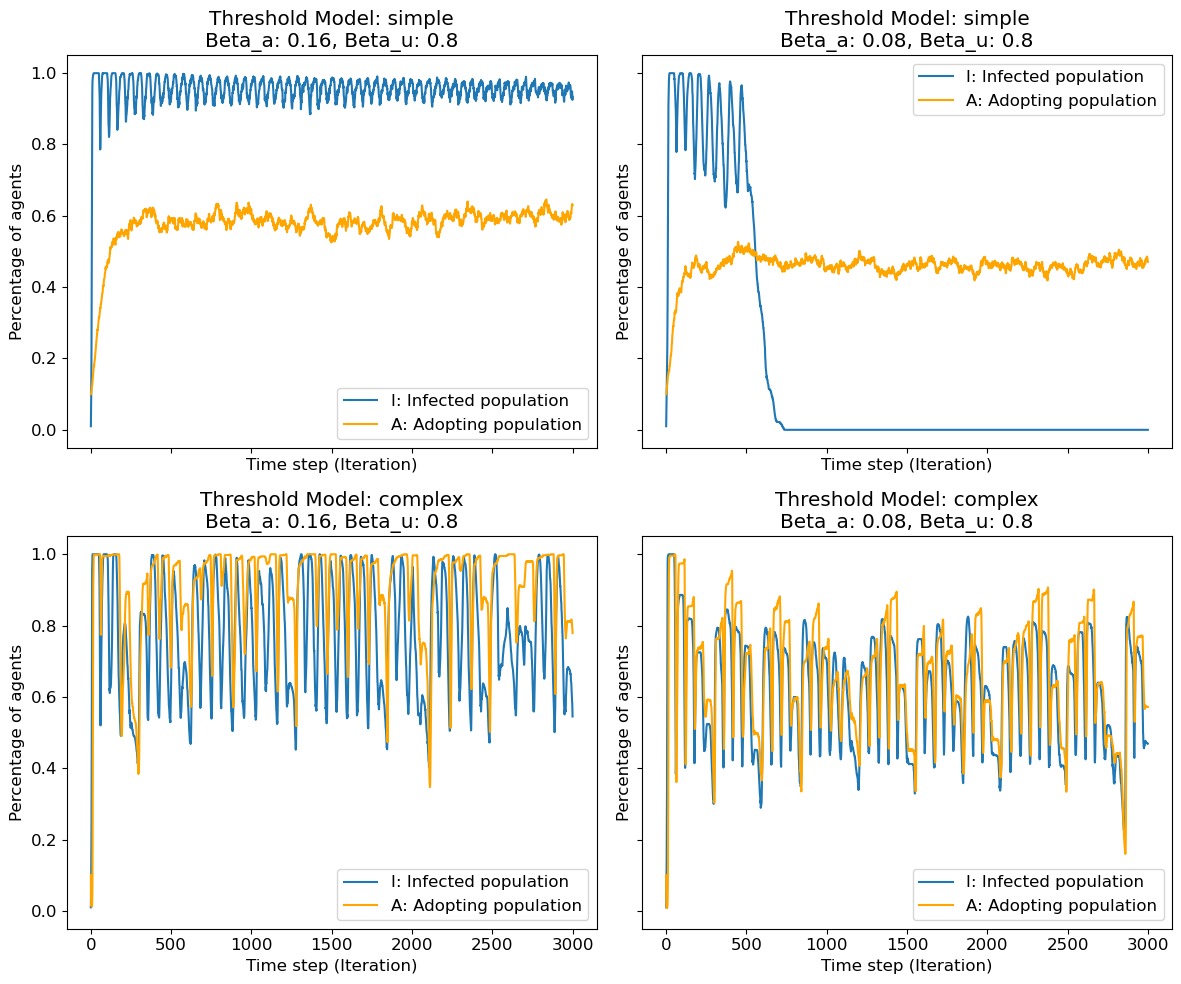

In [10]:
random.seed(111)
np.random.seed(111)

# Set the parameters 
N = 1000 # number of nodes
k = 5 # average degree
time_steps = 3000

a, b = 1.5, 1.5 # beta distribution parameters
beta_u = 0.8 # transmission probability for unaware nodes
# beta_a = . # transmission probability for aware nodes: 5 or 10 times smaller than beta_u
alpha = 0.3 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = 0.7 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.2 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

psi = 0.01 # transmission probability for unaware nodes (only for the simple contagion)
lambda_ = .8 # how the global infection rate affects the awareness threshold (only for the complex contagion)
rho = .5 # turning point of the awareness threshold (only for the complex contagion)

# Plot configuration
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Iterate over threshold formulas and beta_a values
axs_idx = 0
for threshold_formula in ["simple", "complex"]:
    for beta_a in [beta_u/5, beta_u/10]:
        print(f"Threshold Model: {threshold_formula}, Beta_a: {beta_a}, Beta_u: {beta_u}")
        
        # 1. Initialize the TwoLayerNetwork model with the given parameters
        SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, psi=psi, lambda_=lambda_, rho=rho, initial_infected_ratio=0.01, intial_aware_ratio=0.1)
        
        # 2. Run the simulation
        SISModel.run_simulation(time_steps, print_info=False, plot_network=False)

        # 3. Plot the prevalence trend on the current subplot
        SISModel.plot_prevalence_trend(ax=axs[axs_idx])
        axs[axs_idx].set_title(f"Threshold Model: {threshold_formula}\nBeta_a: {beta_a}, Beta_u: {beta_u}")
        axs_idx += 1

        # 4. Print the statistics
        results = SISModel.get_statistics("infection")
        print(f"Final Infection Rate: {results[1]:.3f}, Amplitude: {results[2]:.3f}, Std: {results[3]:.3f}, Dominant Frequency: {results[4]:.3f}, Dominant Amplitude: {results[5]:.3f}")    
        print('-'*20)

plt.tight_layout()
plt.show()
fig.savefig("../figures/simple_vs_complex.png", dpi=300)

## Result 3: How Thresholds are Affected by Global Infection Rate: sensetity to global infection rate ($\lambda$) & turning point ($\rho$)

In [ ]:
def store_simulation_results(simulation_results, matrix_shape, x_range, y_range, test_name):
    # Separate the results into different lists
    infect_rate, infect_amp, infect_sd, infect_seq_freq, infect_seq_amp, aware_rate, aware_amp, aware_sd, aware_seq_freq, aware_seq_amp = zip(*simulation_results)
    
    # Map names to their respective data
    data_dict = {
        "final_infect": infect_rate,
        "final_aware": aware_rate,
        "amp": infect_amp,
        "sd": infect_sd,
        "seq_freq": infect_seq_freq,
        "seq_amp": infect_seq_amp
    }

    # Process each dataset in a loop
    for data_name, data in data_dict.items():
        # Reshape results to match the grid
        reshaped_data = np.array(data).reshape(matrix_shape)
        # Save as CSV
        pd.DataFrame(reshaped_data, index=y_range, columns=x_range).to_csv(f"../results/{test_name}_{data_name}.csv")


def plot_heatmap(data, title, xlabel, ylabel, fig=None, ax=None, cmap='inferno', sigma=1.5):

    smoothed_data = gaussian_filter(data, sigma=sigma) # Apply Gaussian smoothing

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure if no axes provided

    im = ax.imshow(smoothed_data, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap=cmap)
    fig.colorbar(im, ax=ax, label="")  
    ax.set_title("Heatmap of " + title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return im

In [ ]:
# Function to compute amplitude and standard deviation for a given lambda_ and rho
def compute_statistics(lambda_val, rho_val, params, n_realization=10):
    N, k, time_steps, a, b, beta_a, beta_u, alpha, infection_period, threshold_formula, psi, gamma, eta = params

    def extract_statistics(attribute, model):
        _, rate, amp, sd, seq_freq, seq_amp = model.get_statistics(attribute)
        return np.array([rate, amp, sd, seq_freq, seq_amp])

    def run_simulation():
        # Initialize the TwoLayerNetwork model with the given parameters
        model = TwoLayerNetwork(
            N, k, a, b, beta_a, beta_u, alpha, infection_period,
            gamma, eta, threshold_formula, psi=psi, lambda_=lambda_val, rho=rho_val,
            initial_infected_ratio=0.01, intial_aware_ratio=0.1
        )
        model.run_simulation(time_steps, print_info=False, plot_network=False)
        
        # Extract statistics
        infect_stats = extract_statistics("infection", model)
        aware_stats = extract_statistics("awareness", model)
        
        return infect_stats, aware_stats

    # Parallel execution
    results = Parallel(n_jobs=-1)(delayed(run_simulation)() for _ in range(n_realization))
    
    # Aggregate results
    infect_accumulators = np.sum([res[0] for res in results], axis=0)
    aware_accumulators = np.sum([res[1] for res in results], axis=0)

    # Compute averages
    infect_averages = infect_accumulators / n_realization
    aware_averages = aware_accumulators / n_realization

    return tuple(infect_averages) + tuple(aware_averages)

random.seed(111)
np.random.seed(111)

# Parameters for the TwoLayerNetwork model
N = 1000  # Number of nodes
k = 5  # Average degree
time_steps = 2000  # Number of time steps

a, b = 1.5, 1.5  # Beta distribution parameters
beta_u = 0.8  # Transmission probability for unaware nodes
beta_a = beta_u / 10  # Transmission probability for aware nodes
alpha = 0.3  # Recovery probability
infection_period = 50 # number of time steps before a infected node can recover
threshold_formula = "complex"  # "complex" or "simple" contagion
psi = ""  # Awareness transmission probability: not used in the complex contagion model
gamma = 0.7 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.2 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

params = (N, k, time_steps, a, b, beta_a, beta_u, alpha, infection_period, threshold_formula, psi, gamma, eta)

# Ranges for lambda_ (x-axis) and rho (y-axis)
resolution = 30
lambda_range = np.linspace(0, 1, resolution)
rho_range = np.linspace(0, 1, resolution)
lambda_, rho = np.meshgrid(lambda_range, rho_range)

print(f"Total combinations: {len(lambda_range) * len(rho_range)}")

# Flatten the grid for parallel processing
lambda_flat = lambda_.ravel()
rho_flat = rho.ravel()

# Use Joblib for parallel computation
simulation_results = Parallel(n_jobs=-1)(
    delayed(compute_statistics)(lambda_flat[i], rho_flat[i], params) for i in tqdm(range(len(lambda_flat)), desc="Processing")
)

store_simulation_results(simulation_results, lambda_.shape, lambda_range, rho_range, "lambdaRho")

Total combinations: 900


Processing: 100%|██████████| 900/900 [2:54:03<00:00, 11.60s/it]  


#### Plot Heatmap

NameError: name 'plot_heatmap' is not defined

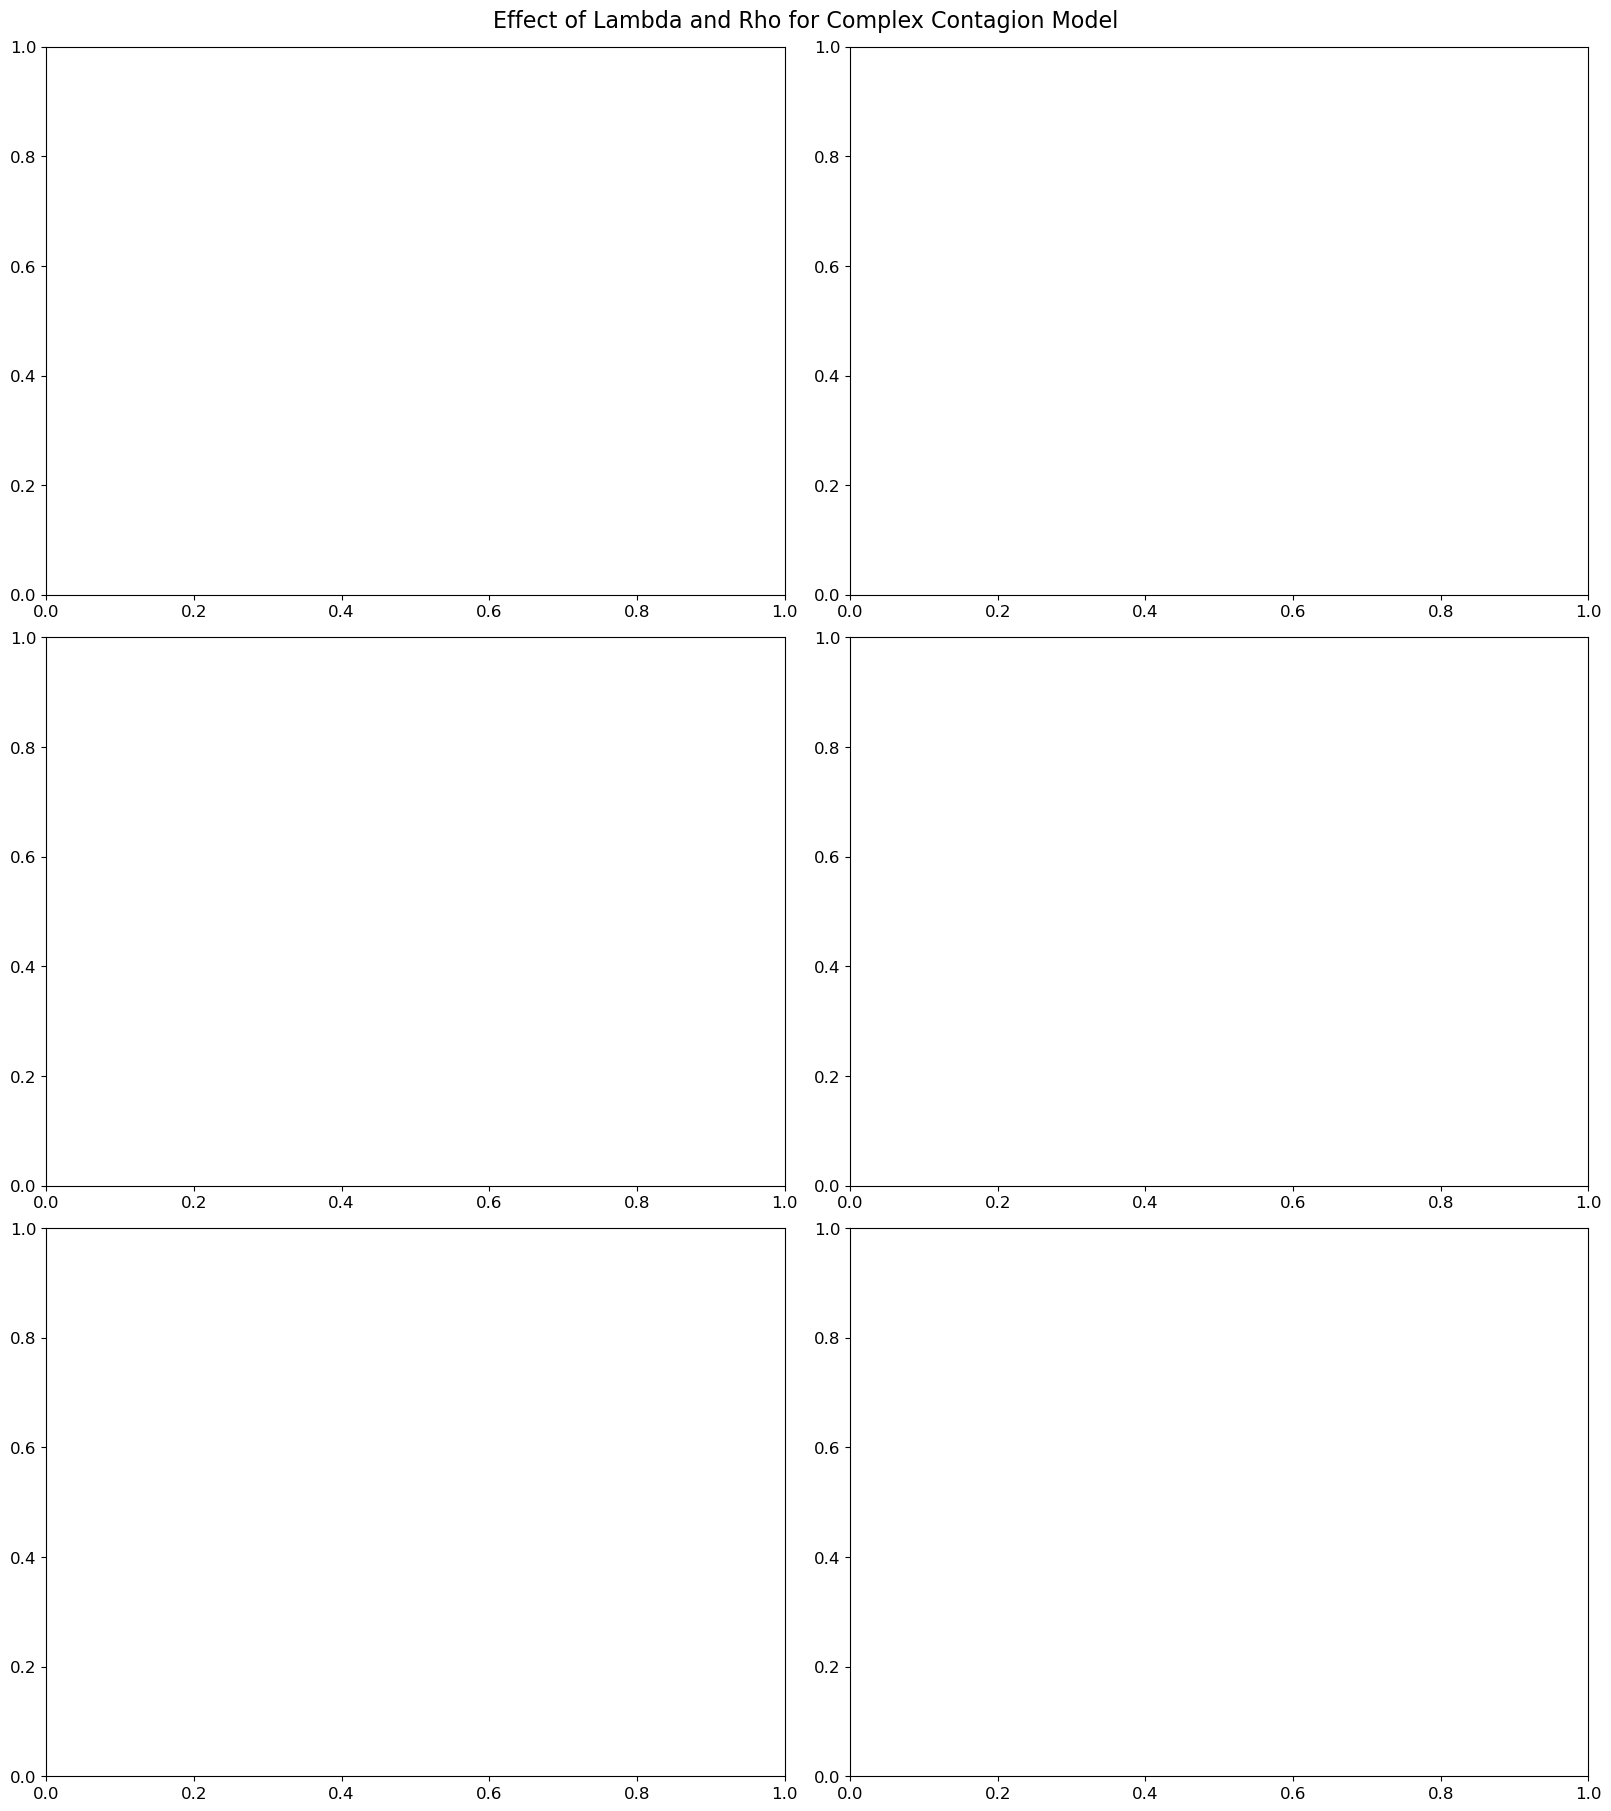

In [6]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(16, 18))
axs = axs.flatten()
fig.suptitle("Effect of Lambda and Rho for Complex Contagion Model", fontsize=16)

final_infect = pd.read_csv("../results/lambdaRho_final_infect.csv", index_col=0)
final_aware = pd.read_csv("../results/lambdaRho_final_aware.csv", index_col=0)
amp = pd.read_csv("../results/lambdaRho_amp.csv", index_col=0)
sd = pd.read_csv("../results/lambdaRho_sd.csv", index_col=0)
seq_freq = pd.read_csv("../results/lambdaRho_seq_freq.csv", index_col=0)
seq_amp = pd.read_csv("../results/lambdaRho_seq_amp.csv", index_col=0)

plot_heatmap(amp, 'Amplitude of Infection Trend', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[0])
plot_heatmap(sd, 'Standard Deviation of Infection Trend', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[1])
plot_heatmap(seq_freq, 'Dominant Frequency of Infection Trend', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[2])
plot_heatmap(seq_amp, 'Dominant Amplitude of Infection Trend', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[3])
plot_heatmap(final_infect, 'Infection Rate', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[4], cmap='viridis')
plot_heatmap(final_aware, 'Awareness Rate', xlabel='Lambda (λ)', ylabel='Rho (ρ)', fig=fig, ax=axs[5], cmap='viridis')
plt.show()
fig.savefig("../figures/lambdaRho_heatmaps.png")

## Results 4: Tuning the Parameters for Rewiring in Adaptive Network: Rewiring Rates ($\gamma$) & Transitivity ($\eta$)

In [28]:
# Function to compute amplitude and standard deviation for a given lambda_ and rho
def compute_statistics(gamma_val, eta_val, params, n_realization=10):
    N, k, time_steps, a, b, beta_a, beta_u, alpha, infection_period, threshold_formula, psi, lambda_, rho = params

    def extract_statistics(attribute, model):
        _, rate, amp, sd, seq_freq, seq_amp = model.get_statistics(attribute)
        return np.array([rate, amp, sd, seq_freq, seq_amp])

    def run_simulation():
        # Initialize the TwoLayerNetwork model with the given parameters
        model = TwoLayerNetwork(
            N, k, a, b, beta_a, beta_u, alpha, infection_period,
            gamma_val, eta_val, threshold_formula, psi=psi, lambda_=lambda_, rho=rho,
            initial_infected_ratio=0.01, intial_aware_ratio=0.1
        ) 
        model.run_simulation(time_steps, print_info=False, plot_network=False)
        
        # Extract statistics
        infect_stats = extract_statistics("infection", model)
        aware_stats = extract_statistics("awareness", model)
        
        return infect_stats, aware_stats

    # Parallel execution
    results = Parallel(n_jobs=-1)(delayed(run_simulation)() for _ in range(n_realization))
    
    # Aggregate results
    infect_accumulators = np.sum([res[0] for res in results], axis=0)
    aware_accumulators = np.sum([res[1] for res in results], axis=0)

    # Compute averages
    infect_averages = infect_accumulators / n_realization
    aware_averages = aware_accumulators / n_realization

    return tuple(infect_averages) + tuple(aware_averages)

# Random seed for reproducibility
random.seed(111)
np.random.seed(111)

# Parameters for the TwoLayerNetwork model
N = 1000  # Number of nodes
k = 5  # Average degree
time_steps = 2000  # Number of time steps

a, b = 1.5, 1.5  # Beta distribution parameters
beta_u = 0.8  # Transmission probability for unaware nodes
beta_a = beta_u / 10  # Transmission probability for aware nodes
alpha = 0.3  # Recovery probability
infection_period = 50  # Infection period before recovery

threshold_formula = "complex"  # "complex" or "simple" contagion
psi = ""  # Awareness transmission probability (simple contagion)
lambda_ = 0.8  # Awareness threshold parameter (complex contagion)
rho = 0.5  # Awareness threshold turning point (complex contagion)

params = (N, k, time_steps, a, b, beta_a, beta_u, alpha, infection_period, threshold_formula, psi, lambda_, rho)

# Ranges for gamma (x-axis) and eta (y-axis)
resolution = 30
gamma_range = np.linspace(0, 1, resolution)  
eta_range = np.linspace(0, 1, resolution)
gamma, eta = np.meshgrid(gamma_range, eta_range)

print(f"Total combinations: {len(gamma_range) * len(eta_range)}")

# Flatten the grid for parallel processing
gamma_flat = gamma.ravel()
eta_flat = eta.ravel()

# Use Joblib for parallel computation 
simulation_results = Parallel(n_jobs=-1)(
    delayed(compute_statistics)(gamma_flat[i], eta_flat[i], params) for i in tqdm(range(len(gamma_flat)), desc="Processing")
)

store_simulation_results(simulation_results, gamma.shape, gamma_range, eta_range, "gammaEta")

Total combinations: 900


Processing: 100%|██████████| 900/900 [3:17:17<00:00, 13.15s/it]  


#### Plot Heatmap

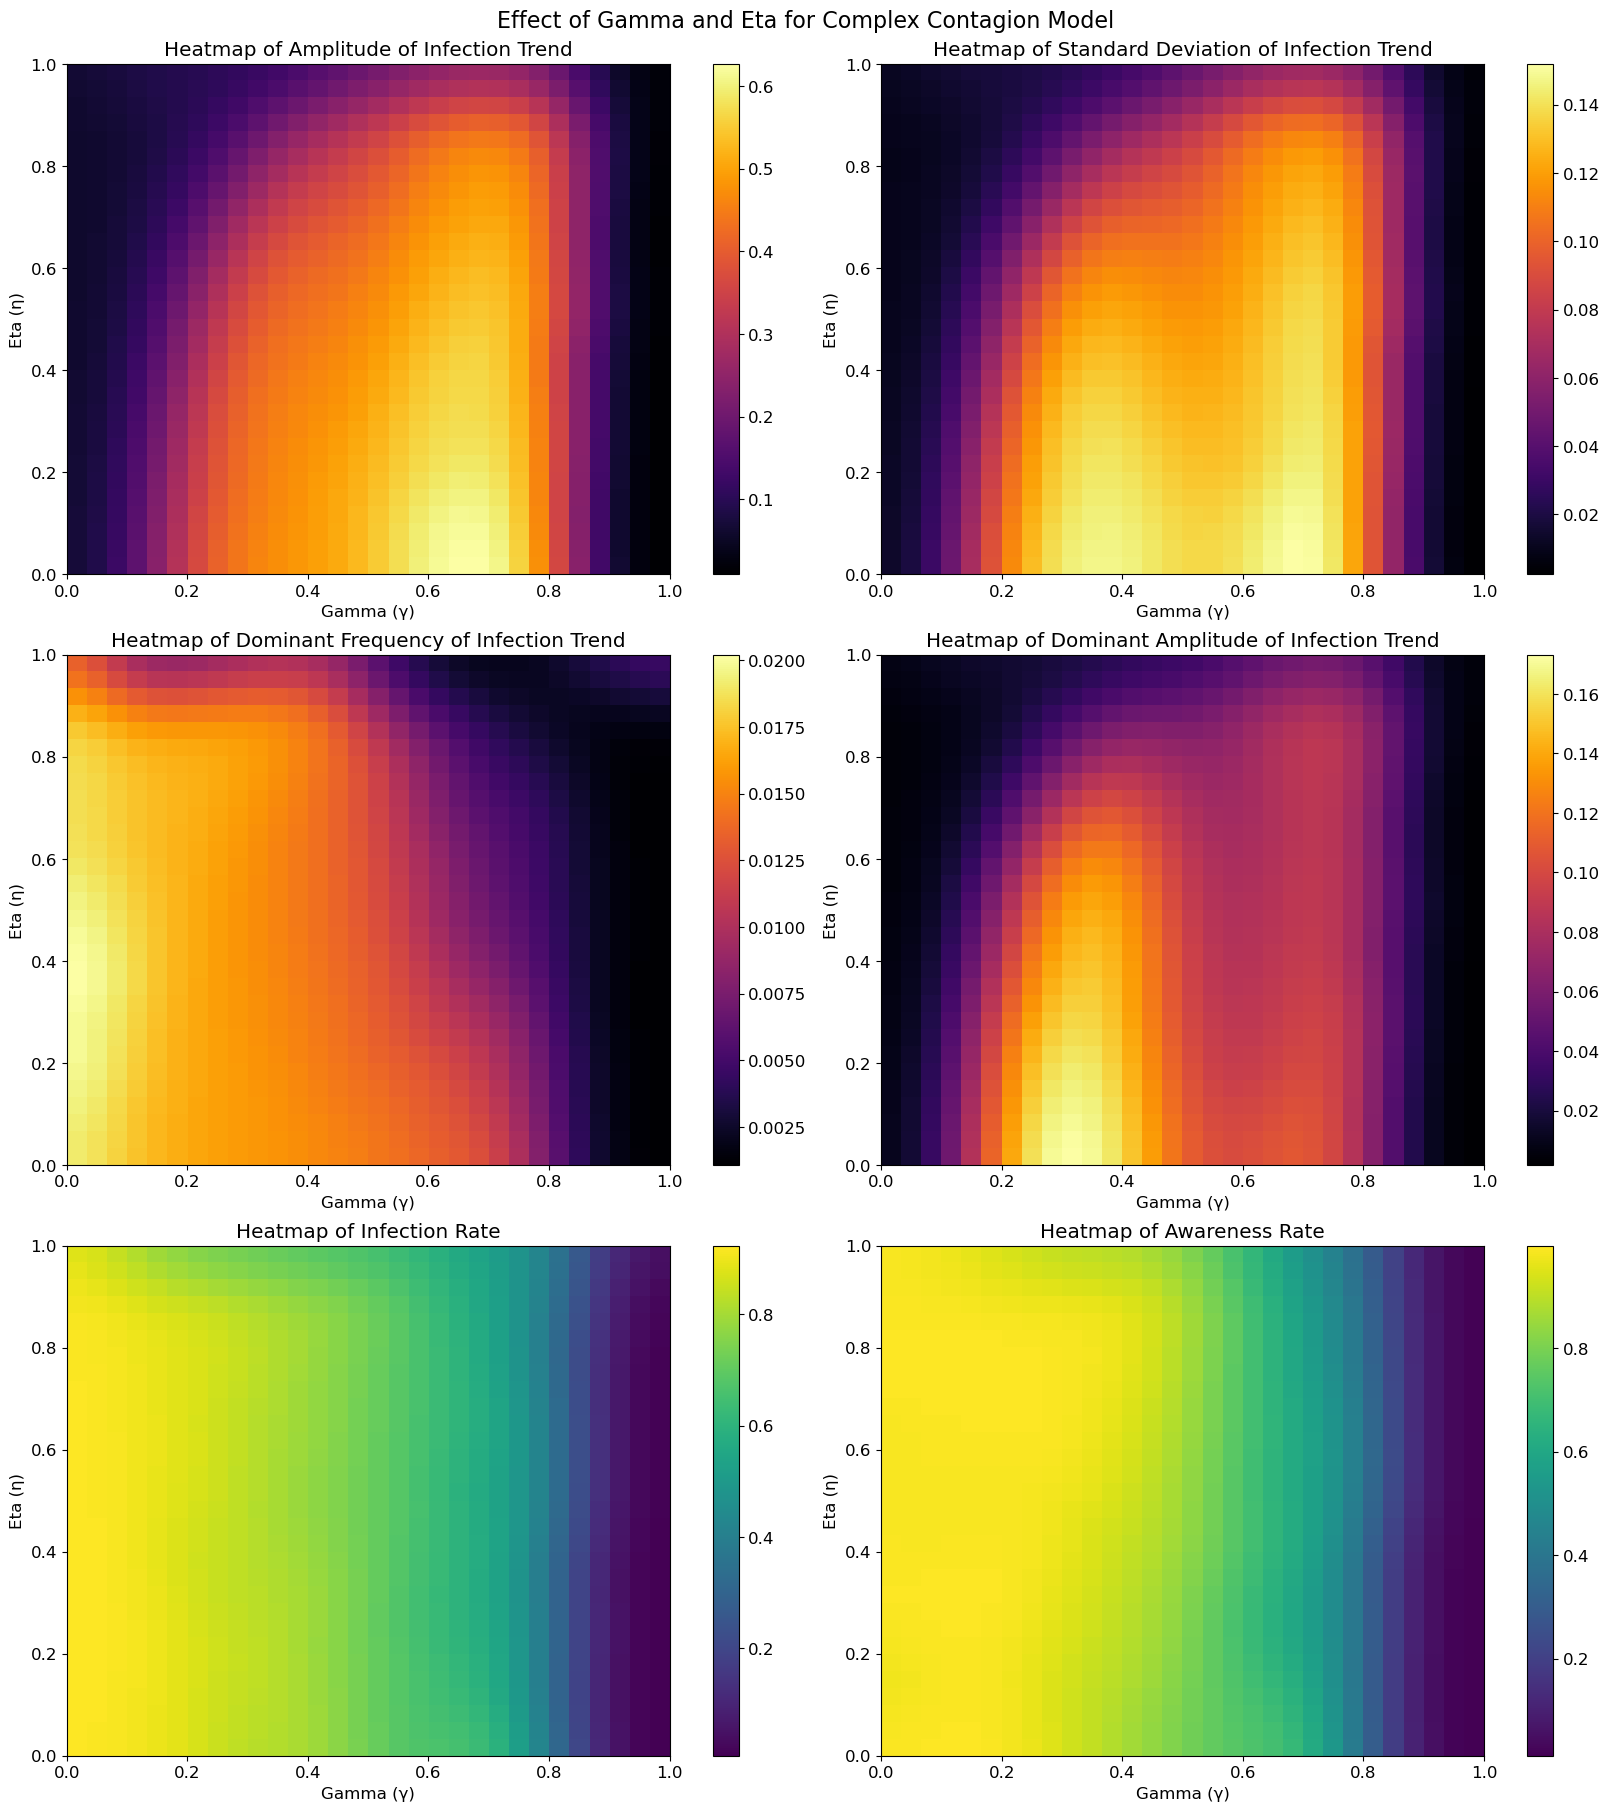

In [46]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(16, 18))
axs = axs.flatten()
fig.suptitle("Effect of Gamma and Eta for Complex Contagion Model", fontsize=16)

final_infect = pd.read_csv("../results/gammaEta_final_infect.csv", index_col=0)
final_aware = pd.read_csv("../results/gammaEta_final_aware.csv", index_col=0)
amp = pd.read_csv("../results/gammaEta_amp.csv", index_col=0)
sd = pd.read_csv("../results/gammaEta_sd.csv", index_col=0)
seq_freq = pd.read_csv("../results/gammaEta_seq_freq.csv", index_col=0)
seq_amp = pd.read_csv("../results/gammaEta_seq_amp.csv", index_col=0)

plot_heatmap(amp, 'Amplitude of Infection Trend', xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[0])
plot_heatmap(sd, 'Standard Deviation of Infection Trend', xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[1])
plot_heatmap(seq_freq, 'Dominant Frequency of Infection Trend', xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[2])
plot_heatmap(seq_amp, 'Dominant Amplitude of Infection Trend', xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[3])
plot_heatmap(final_infect, 'Infection Rate', xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[4], cmap='viridis')
plot_heatmap(final_aware, 'Awareness Rate',xlabel='Gamma (γ)', ylabel='Eta (η)', fig=fig, ax=axs[5], cmap='viridis')
plt.show()
fig.savefig("../figures/gammaEta_heatmaps.png")

## Result 5: Network Typology: ER, WS, BA

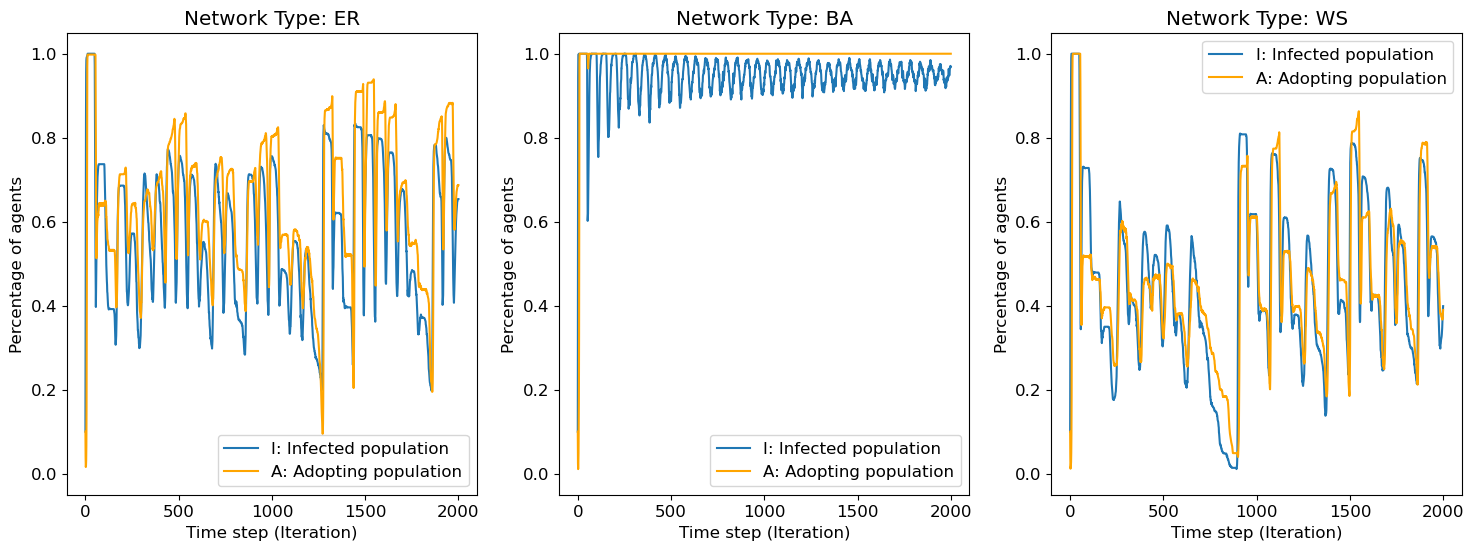

In [27]:
random.seed(111)
np.random.seed(111)

N = 1000 # number of nodes
k = 5 # average degree
time_steps = 2000

a, b = 1.5, 1.5 # beta distribution parameters
beta_u = 0.8 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes: 5 or 10 times smaller than beta_u
alpha = 0.3 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = .7 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = .2 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

threshold_formula = "complex" # "complex" or "simple" contagion
lambda_ = .8 # how the global infection rate affects the awareness threshold
rho = .5 # turning point of the awareness threshold

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = axs.flatten()
axs_idx = 0

for network_type in ["ER", "BA", "WS"]:
  SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_=lambda_, rho=rho, initial_infected_ratio=0.1, intial_aware_ratio=0.1, network_type=network_type)
  
  # SISModel.plot_network("physical", component_num=1)
  SISModel.run_simulation(time_steps, print_info=False, plot_network=False)
  # SISModel.plot_network("physical", component_num=1)

  SISModel.plot_prevalence_trend(ax=axs[axs_idx])
  axs[axs_idx].set_title(f"Network Type: {network_type}")
  axs_idx += 1

plt.show()

## (Supplementary and Testing)

In [ ]:
plt.hist([n.aware_therold for n in SISModel.nodes], bins=50, edgecolor='black')
plt.xlim(0, 1)
plt.title("Awareness Thresholds")
plt.show()

plt.hist(SISModel.adjust_awareness_thresholds, bins=50, edgecolor='black')
plt.xlim(0, 1)
plt.title("Adjusted Awareness Thresholds")
plt.show()

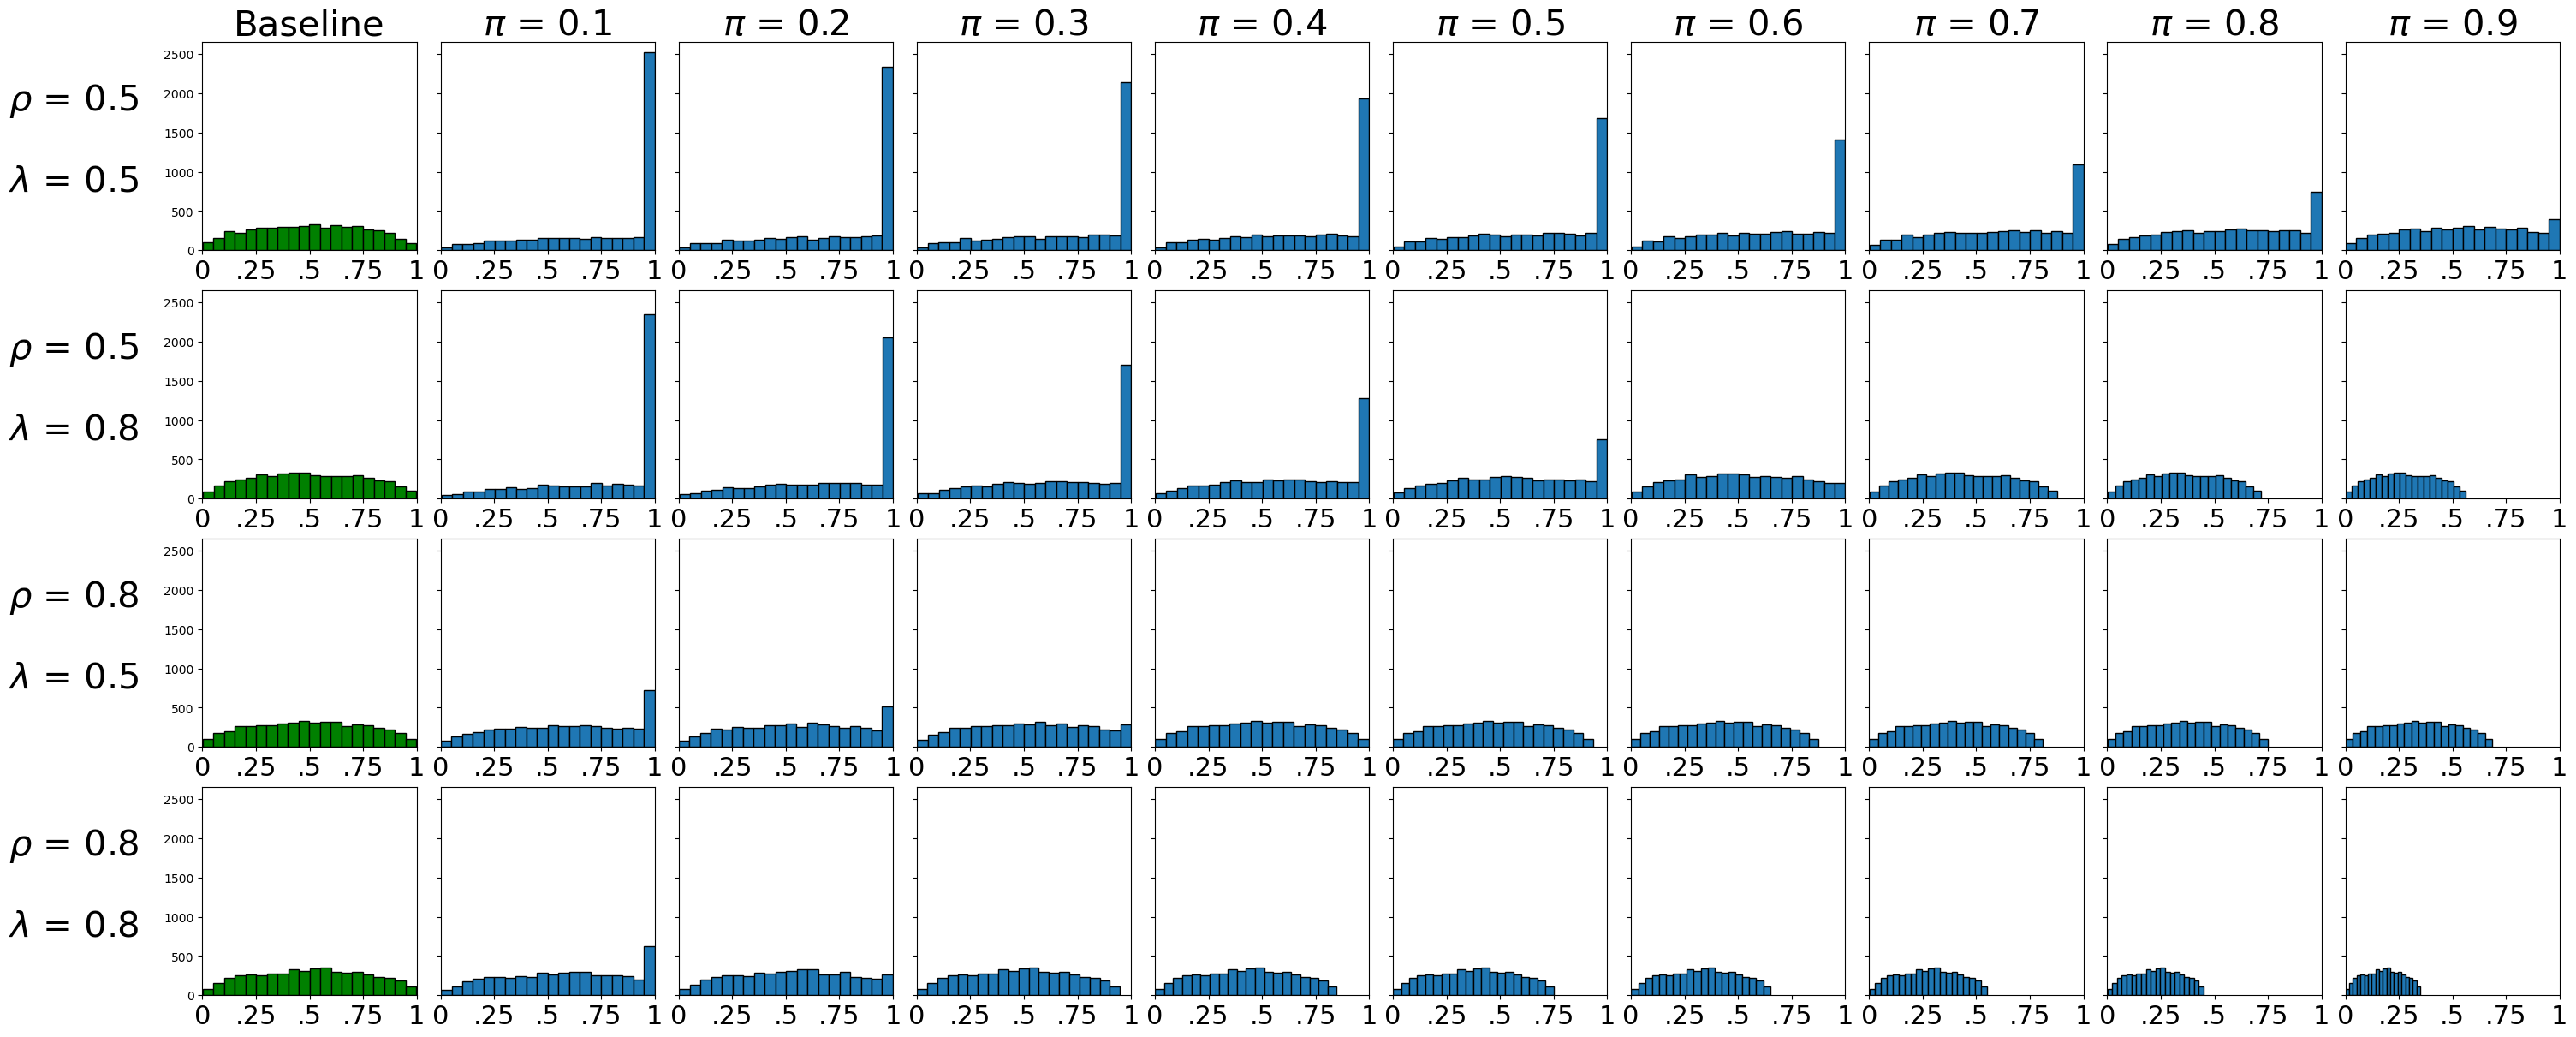

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_beta_distribution(axs, alpha, beta, lambda_, rho, sample_size=5000, prevalence_rates=None, set_title=False):
    if prevalence_rates is None:
        prevalence_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    x = np.random.beta(alpha, beta, sample_size)

    axs[0].hist(x, bins=20, edgecolor='black', color='green')
    axs[0].set_xlim(0, 1)
    axs[0].xaxis.set_tick_params(labelsize=22)
    axs[0].set_xticks([0, 0.25, 0.5, 0.75, 1])
    axs[0].set_xticklabels(['0', '.25', '.5', '.75', '1'])
    if set_title:
        axs[0].set_title('Baseline')
        axs[0].title.set_fontsize(30)
        
    
    for i, pi in enumerate(prevalence_rates):
        adjusted_x = np.clip(x * (1 - lambda_ * pi) * (1 / rho), 0, 1)
        axs[i + 1].hist(adjusted_x, bins=20, edgecolor='black')
        axs[i + 1].set_xlim(0, 1)
        axs[i + 1].xaxis.set_tick_params(labelsize=22)
        axs[i + 1].set_xticks([0, 0.25, 0.5, 0.75, 1])
        axs[i + 1].set_xticklabels(['0', '.25', '.5', '.75', '1'])
        if set_title:
            axs[i + 1].set_title(r"$\pi$ = " + f"{pi}") # format
            axs[i + 1].title.set_fontsize(30)

    return axs

# Define parameters
alpha, beta = 1.5, 1.5
lambda_rho_pairs = [(0.5, 0.5), (0.8, 0.5), (0.5, 0.8), (0.8, 0.8)]
# lambda_rho_pairs = [(0.1, 0.9), (0.1, 0.1), (0.9, 0.9), (0.9, 0.1)]
num_plots = len(lambda_rho_pairs)
prevalence_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# prevalence_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

fig, axs = plt.subplots(num_plots, len(prevalence_rates) + 1, figsize=(30, 3 * num_plots), sharey=True, constrained_layout=True)

for row, (lambda_, rho) in enumerate(lambda_rho_pairs):
    if row == 0: set_title=True
    else: set_title=False
    plot_beta_distribution(axs[row], alpha, beta, lambda_, rho, prevalence_rates=prevalence_rates, set_title=set_title)
    axs[row, 0].set_ylabel(r"$\rho$ = " + f"{rho}\n\n" + r"$\lambda$ = " + f"{lambda_}", fontsize=30, fontweight='normal', rotation=0)
    axs[row, 0].yaxis.set_label_coords(-0.6, 0.25)

plt.show()
fig.savefig("../figures/adjusted_threshold_distribution.png")

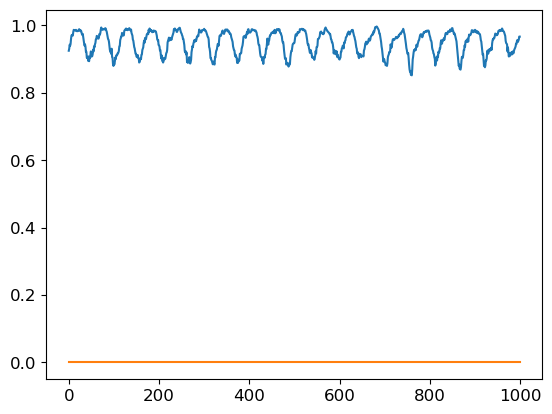

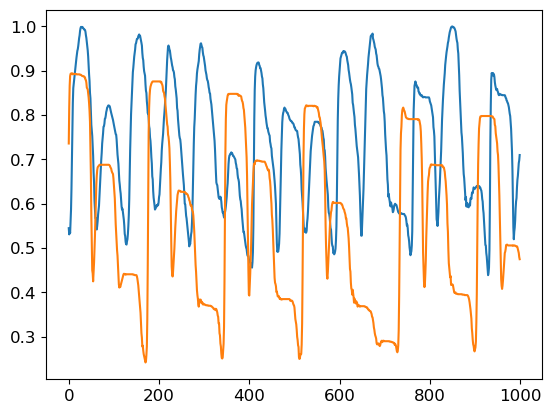

Simple, Beta_a=0.16: Dominant frequency = 0.02, Amplitude = 0.04
Simple, Beta_a=0.08: Dominant frequency = 0.00, Amplitude = 0.00
Complex, Beta_a=0.16: Dominant frequency = 0.01, Amplitude = 0.10
Complex, Beta_a=0.08: Dominant frequency = 0.01, Amplitude = 0.14


In [55]:
t = 1000
dt = 1
infection_proportion_1 = np.array(infection_results[0][-t:])/1000 # simple, beta_a=0.16
infection_proportion_2 = np.array(infection_results[1][-t:])/1000  # simple, beta_a=0.08
infection_proportion_3 = np.array(infection_results[2][-t:])/1000  # complex, beta_a=0.16
infection_proportion_4 = np.array(infection_results[3][-t:])/1000  # complex, beta_a=0.08
plt.plot(range(t), infection_proportion_1, label='I: Infected population')
plt.plot(range(t), infection_proportion_2, label='I: Infected population')
plt.show()
plt.plot(range(t), infection_proportion_3, label='I: Infected population')
plt.plot(range(t), infection_proportion_4, label='I: Infected population')
plt.show()


# Conduct fourier analysis for the four time series
dominant_freq_1, dominant_amp_1 = fourier_analysis(infection_proportion_1, t, dt)
dominant_freq_2, dominant_amp_2 = fourier_analysis(infection_proportion_2, t, dt)
dominant_freq_3, dominant_amp_3 = fourier_analysis(infection_proportion_3, t, dt)
dominant_freq_4, dominant_amp_4 = fourier_analysis(infection_proportion_4, t, dt)

# print the results
print(f"Simple, Beta_a=0.16: Dominant frequency = {dominant_freq_1:.2f}, Amplitude = {dominant_amp_1:.2f}")
print(f"Simple, Beta_a=0.08: Dominant frequency = {dominant_freq_2:.2f}, Amplitude = {dominant_amp_2:.2f}")
print(f"Complex, Beta_a=0.16: Dominant frequency = {dominant_freq_3:.2f}, Amplitude = {dominant_amp_3:.2f}")
print(f"Complex, Beta_a=0.08: Dominant frequency = {dominant_freq_4:.2f}, Amplitude = {dominant_amp_4:.2f}")

In [ ]:
print(SISModel.nodes[1].get_physical_neighbors_id(), SISModel.nodes[1].get_virtual_neighbors_id())

degrees = [degree for _, degree in SISModel.get_network('physical').degree()]
plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
plt.show()

# degrees = [degree for _, degree in SISModel.get_network('virtual').degree()]
# plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
# plt.show()

In [ ]:
N = 100
k = 5 # average degree
time_steps = 100

a, b = 1.5, 1.25 # beta distribution parameters
beta_u = 0.85 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes
alpha = 0.25 # recovery probability 
infection_period = 50 # number of time steps before a infected node can recover
gamma = 0.8 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.8 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta

threshold_formula = "complex" # "complex" or "simple" contagion
lambda_ = 0.7 # how the global infection rate affects the awareness threshold
rho  = 0.6 # turning point of the awareness threshold

SISModel = TwoLayerNetwork(N, k, a, b, beta_a, beta_u, alpha, infection_period, gamma, eta, threshold_formula, lambda_=lambda_, rho=rho, initial_infected_ratio=0.01, intial_aware_ratio=0.1)
SISModel.run_simulation(time_steps, print_info=True, plot_network=True)

SISModel.plot_network("physical")
SISModel.plot_network("virtual")
SISModel.plot_prevalence_trend()

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

max_lag = 1500

y = y_simple[-2000:]

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(y, model='multiplicative', period=100)
# Additive Decomposition
additive_decomposition = seasonal_decompose(y, model='additive', period=100)

plt.rcParams.update({'figure.figsize': (8,6)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_acf(y, lags=max_lag, alpha=0.05)
plt.show()

y = y_complex[-2000:]

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(y, model='multiplicative', period=100)
# Additive Decomposition
additive_decomposition = seasonal_decompose(y, model='additive', period=100)

plt.rcParams.update({'figure.figsize': (8,6)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_acf(y, lags=max_lag, alpha=0.05)
plt.show()

max_lag = 1500
acf_values = acf(y_complex, nlags=max_lag, fft=True)
plt.figure(figsize=(10, 4))
plt.stem(range(max_lag + 1))
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.show()

# ---------------------------------------------------------------------
# 頻譜分析 (Periodogram) - 觀察哪個頻率最強
# ---------------------------------------------------------------------
# 預設取樣頻率 fs = 1 (每個 time step 視為 1 個取樣單位)
freqs, psd = periodogram(y_complex[-1000:], fs=1.0)

plt.figure(figsize=(8, 3))
plt.plot(freqs, psd, marker="o", linestyle="--")
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.xlim(0, 0.5)  # Nyquist 頻率對應 0.5 (若 fs=1)
plt.show()

# 找出頻譜主峰
peak_idx = np.argmax(psd)
peak_freq = freqs[peak_idx]
peak_power = psd[peak_idx]

if peak_freq > 0:
    estimated_period = 1.0 / peak_freq
    print(f"頻譜顯示最強頻率 ~ {peak_freq:.3f} (Power={peak_power:.3f})")
    print(f"=> 對應週期 ~ {estimated_period:.2f} time steps")
else:
    print("頻譜主峰在 freq=0，可能為趨勢或無明顯週期性。")

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

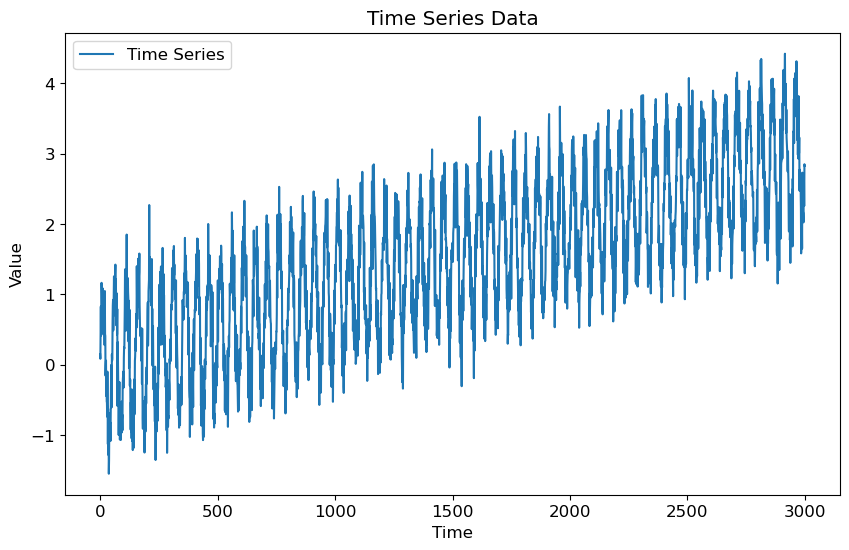

NameError: name 'acf' is not defined

In [ ]:
from scipy.signal import periodogram, find_peaks

# ---------------------------------------------------------------------
# 1. 產生一個示範性的「振盪+噪音」時間序列
# ---------------------------------------------------------------------
np.random.seed(42)
n_points = 3000
t = np.arange(n_points)
freq = 0.02  # 週期 ~ 1/freq => ~50 點一個週期
amplitude = 1.0
noise_level = 0.3

# 加入緩慢趨勢 term 與隨機噪音，營造較接近實務的複合時間序列
y = amplitude * np.sin(2 * np.pi * freq * t) \
    + 0.001 * t  \
    + noise_level * np.random.randn(n_points)

plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.legend()
plt.show()

# ---------------------------------------------------------------------
# 3. 自相關分析 (ACF) - 檢查週期性
# ---------------------------------------------------------------------
max_lag = 100  # 要檢查的落後期數，可視資料長度而定
acf_vals = acf(y, nlags=max_lag, fft=True)
lags = np.arange(len(acf_vals))

# 繪製 ACF
plt.figure(figsize=(8, 3))
plt.stem(lags, acf_vals)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.show()

# 尋找 ACF 是否有「顯著峰值」(排除 lag=0 的那一點)
# 這裡僅以 find_peaks 作示範，實務上可搭配臨界值或信賴區間。
peak_indices, _ = find_peaks(acf_vals, height=0)  # height=0 表示找出大於 0 的峰
valid_peaks = peak_indices[peak_indices > 0]     # 排除 lag=0

if len(valid_peaks) > 0:
    first_peak_lag = valid_peaks[0]
    print(f"ACF 第一個顯著峰值出現在 lag = {first_peak_lag}")
    print("=> 可能的主要週期 ≈", first_peak_lag, "（或是其倍數）")
else:
    print("ACF 未發現顯著峰值，或沒有明顯週期性。")

# ---------------------------------------------------------------------
# 4. 頻譜分析 (Periodogram) - 觀察哪個頻率最強
# ---------------------------------------------------------------------
# 預設取樣頻率 fs = 1 (每個 time step 視為 1 個取樣單位)
freqs, psd = periodogram(y, fs=1.0)

plt.figure(figsize=(8, 3))
plt.plot(freqs, psd, marker="o", linestyle="--")
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.xlim(0, 0.5)  # Nyquist 頻率對應 0.5 (若 fs=1)
plt.show()

# 找出頻譜主峰
peak_idx = np.argmax(psd)
peak_freq = freqs[peak_idx]
peak_power = psd[peak_idx]

if peak_freq > 0:
    estimated_period = 1.0 / peak_freq
    print(f"頻譜顯示最強頻率 ~ {peak_freq:.3f} (Power={peak_power:.3f})")
    print(f"=> 對應週期 ~ {estimated_period:.2f} time steps")
else:
    print("頻譜主峰在 freq=0，可能為趨勢或無明顯週期性。")

# ---------------------------------------------------------------------
# 5. （選擇性）波峰偵測 - 直接在原始 y 找相鄰波峰，算平均間距
# ---------------------------------------------------------------------
peak_indices_in_y, _ = find_peaks(y, height=0)  # 依需求可調參數
if len(peak_indices_in_y) >= 2:
    # 相鄰波峰的距離
    peak_distances = np.diff(peak_indices_in_y)
    mean_peak_dist = np.mean(peak_distances)
    print(f"從原始波峰偵測，平均週期 ~ {mean_peak_dist:.2f} time steps")
else:
    print("波峰不足以判定週期，或資料波形不明顯。")

Fourier Analysis:
  Dominant Frequency: 0.200
  Dominant Amplitude: 2.045

Wavelet Analysis (pywt):
  Estimated Frequency from Wavelet: 0.203

Autocorrelation Analysis:
  Estimated Frequency: 0.200

Harmonic Regression:
  Fitted Amplitude: 2.045
  Fitted Frequency: 0.200
  Fitted Phase: 0.500
  Fitted Offset: 10.010


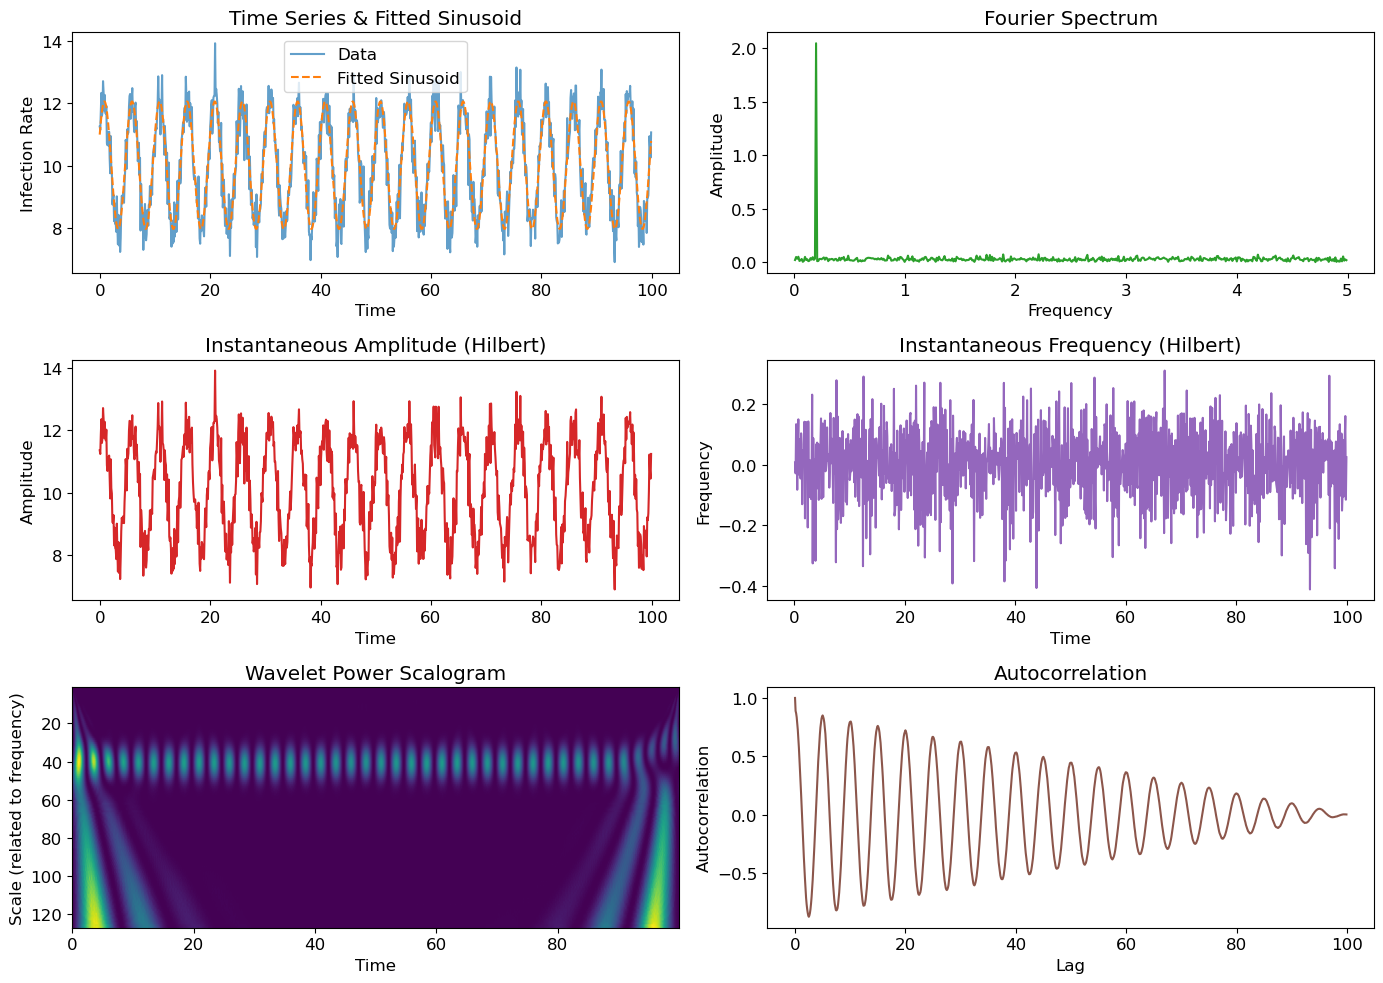

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import hilbert, find_peaks
from scipy.optimize import curve_fit
import pywt  # Python Wavelets

# =============================
# 1. Generate synthetic data
# =============================
np.random.seed(42)
dt = 0.1                     # time step
t = np.arange(0, 100, dt)      # time vector (e.g., days)

# True parameters for the synthetic sinusoidal signal
true_amp = 2.0               # amplitude
true_freq = 0.2              # frequency in cycles per time unit
true_phase = np.pi / 6       # phase shift
baseline = 10                # baseline infection rate

# Synthetic infection rate data with added noise
noise = np.random.normal(0, 0.5, len(t))
data = baseline + true_amp * np.sin(2 * np.pi * true_freq * t + true_phase) + noise

# =====================================
# 2. Fourier Analysis (FFT Method)
# =====================================
N = len(t)
data_fft = fft(data)
freq = fftfreq(N, dt)

# Only consider the positive half of frequencies
mask = freq > 0
freq_pos = freq[mask]
fft_magnitude = np.abs(data_fft[mask]) * 2 / N  # scale for amplitude estimation

# Identify the dominant frequency and its amplitude
dominant_idx = np.argmax(fft_magnitude)
dominant_freq = freq_pos[dominant_idx]
dominant_amp = fft_magnitude[dominant_idx]

print("Fourier Analysis:")
print("  Dominant Frequency: {:.3f}".format(dominant_freq))
print("  Dominant Amplitude: {:.3f}".format(dominant_amp))

# =====================================
# 3. Hilbert Transform
# =====================================
# Compute the analytic signal to obtain instantaneous amplitude and phase
analytic_signal = hilbert(data)
inst_amplitude = np.abs(analytic_signal)
inst_phase = np.unwrap(np.angle(analytic_signal))
# Instantaneous frequency: derivative of phase divided by 2π (note: dt is the sampling interval)
inst_frequency = np.diff(inst_phase) / (2.0 * np.pi * dt)

# =====================================
# 4. Wavelet Analysis (using pywt)
# =====================================
# Use the Morlet wavelet ('morl') for a continuous wavelet transform
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(data, scales, 'morl', dt)
power = (np.abs(coefficients)) ** 2  # wavelet power spectrum
avg_power = np.mean(power, axis=1)
dominant_scale_idx = np.argmax(avg_power)
# frequencies array from pywt.cwt provides the equivalent Fourier frequencies
dominant_wavelet_freq = frequencies[dominant_scale_idx]

print("\nWavelet Analysis (pywt):")
print("  Estimated Frequency from Wavelet: {:.3f}".format(dominant_wavelet_freq))

# =====================================
# 5. Autocorrelation Analysis
# =====================================
# Compute autocorrelation by correlating the demeaned series with itself
autocorr_full = np.correlate(data - np.mean(data), data - np.mean(data), mode='full')
autocorr = autocorr_full[autocorr_full.size // 2:]
autocorr /= autocorr[0]  # normalization

# Find peaks in the autocorrelation function (excluding lag zero)
peaks, _ = find_peaks(autocorr)
if len(peaks) > 0:
    first_peak = peaks[0]
    estimated_period = first_peak * dt  # convert lag index to time
    estimated_frequency_acf = 1 / estimated_period
    print("\nAutocorrelation Analysis:")
    print("  Estimated Frequency: {:.3f}".format(estimated_frequency_acf))
else:
    print("\nAutocorrelation Analysis: No significant peaks found.")

# =====================================
# 6. Harmonic Regression
# =====================================
# Define a sinusoidal model for curve fitting
def sinusoid(t, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * t + phi) + offset

# Initial guess: amplitude, frequency, phase, offset
initial_guess = [ (np.max(data) - np.min(data)) / 2, dominant_freq, 0, np.mean(data) ]
params, covariance = curve_fit(sinusoid, t, data, p0=initial_guess)
fitted_A, fitted_f, fitted_phi, fitted_offset = params

print("\nHarmonic Regression:")
print("  Fitted Amplitude: {:.3f}".format(fitted_A))
print("  Fitted Frequency: {:.3f}".format(fitted_f))
print("  Fitted Phase: {:.3f}".format(fitted_phi))
print("  Fitted Offset: {:.3f}".format(fitted_offset))

# =====================================
# 7. Plotting Results
# =====================================
plt.figure(figsize=(14, 10))

# (a) Time series and harmonic regression fit
plt.subplot(3, 2, 1)
plt.plot(t, data, label='Data', color='C0', alpha=0.7)
plt.plot(t, sinusoid(t, *params), label='Fitted Sinusoid', color='C1', linestyle='--')
plt.title("Time Series & Fitted Sinusoid")
plt.xlabel("Time")
plt.ylabel("Infection Rate")
plt.legend()

# (b) Fourier spectrum
plt.subplot(3, 2, 2)
plt.plot(freq_pos, fft_magnitude, color='C2')
plt.title("Fourier Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

# (c) Hilbert instantaneous amplitude
plt.subplot(3, 2, 3)
plt.plot(t, inst_amplitude, color='C3')
plt.title("Instantaneous Amplitude (Hilbert)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# (d) Hilbert instantaneous frequency
plt.subplot(3, 2, 4)
plt.plot(t[1:], inst_frequency, color='C4')
plt.title("Instantaneous Frequency (Hilbert)")
plt.xlabel("Time")
plt.ylabel("Frequency")

# (e) Wavelet power scalogram
plt.subplot(3, 2, 5)
extent = [t[0], t[-1], scales[-1], scales[0]]
plt.imshow(power, extent=extent, aspect='auto', cmap='viridis')
plt.title("Wavelet Power Scalogram")
plt.xlabel("Time")
plt.ylabel("Scale (related to frequency)")

# (f) Autocorrelation function
plt.subplot(3, 2, 6)
lags = np.arange(len(autocorr)) * dt
plt.plot(lags, autocorr, color='C5')
plt.title("Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()

plt.show()